<h1><center>APPs Influence on Gene Expression in the Mouse Frontal Cortex</h1>

# Introduction

This notebook analyzes DNA microarray gene expression data from mouse frontal cortex to examine transcriptional changes associated with genetic manipulation of APP and related family members.


In [1]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Import and Inspect Data

The data used in this study can be accesses through the Gene Expression Omnibus (GEO) hosted by the National Center for Biotechnology Information (NCBI): https://www.ncbi.nlm.nih.gov/gds/ 

The GEO accession viewer for this data: 

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE25926

**Full citation for this research:**

Aydin, D., Filippov, M. A., Tschäpe, J., Gretz, N., Prinz, M., Eils, R., Brors, B., & Müller, U. C. (2011). Comparative transcriptome profiling of amyloid precursor protein family members in the adult cortex. BMC Genomics, 12(1), 160. https://doi.org/10.1186/1471-2164-12-160


In [2]:
import logging
import warnings
from pandas.errors import DtypeWarning

logging.getLogger("GEOparse").setLevel(logging.WARNING)
warnings.filterwarnings("ignore", category=DtypeWarning)

data = GEOparse.get_GEO(filepath="data/GDS4414_full.soft")

17-Feb-2026 14:45:53 ERROR GEOparse - Cannot recognize type Annotation


In [3]:
# Convert metadata to dataframe
sample_metadata = pd.DataFrame.from_dict(data.metadata, orient='index')

# Inspect metadata
print(sample_metadata)

                                                                          0
title                     Amyloid Precursor Protein APP family members: ...
description               Analysis of prefrontal cortex of adult wild-ty...
type                                          Expression profiling by array
pubmed_id                                                          21435241
platform                                                            GPL1261
platform_organism                                              Mus musculus
platform_technology_type                            in situ oligonucleotide
feature_count                                                         45101
sample_organism                                                Mus musculus
sample_type                                                             RNA
channel_count                                                             1
sample_count                                                             15
value_type  

In [4]:
full_df = data.table

In [5]:
print(full_df.shape)
print(full_df.head())

(45101, 37)
         ID_REF IDENTIFIER  GSM636860  GSM636861  GSM636862  GSM636863  \
0    1415670_at      Copg1    9.65531    9.64880    9.64880    9.64288   
1    1415671_at   Atp6v0d1   12.08490   12.10560   12.12760   12.17850   
2    1415672_at     Golga7   11.40400   11.34900   11.47450   11.40460   
3    1415673_at       Psph    8.53810    8.57625    8.71893    8.54500   
4  1415674_a_at    Trappc4    9.57747    9.52363    9.59707    9.52821   

   GSM636864  GSM636865  GSM636866  GSM636867  ...  Platform_ORF  \
0    9.77154    9.69784    9.64765    9.45991  ...           NaN   
1   12.11860   12.20880   12.11270   12.12640  ...           NaN   
2   11.37560   11.41260   11.37470   11.36550  ...           NaN   
3    8.66342    8.64001    8.53474    8.44488  ...           NaN   
4    9.67610    9.53456    9.59649    9.38794  ...           NaN   

   Platform_SPOTID  Chromosome location  \
0              NaN           6 39.13 cM   
1              NaN                 8 D3   
2    

In [6]:
full_df.iloc[:5, :5]


,ID_REF,IDENTIFIER,GSM636860,GSM636861,GSM636862
0,1415670_at,Copg1,9.65531,9.64880,9.64880
1,1415671_at,Atp6v0d1,12.08490,12.10560,12.12760
2,1415672_at,Golga7,11.40400,11.34900,11.47450
3,1415673_at,Psph,8.53810,8.57625,8.71893
4,1415674_a_at,Trappc4,9.57747,9.52363,9.59707


In [7]:
print(full_df.columns)


Index(['ID_REF', 'IDENTIFIER', 'GSM636860', 'GSM636861', 'GSM636862',
       'GSM636863', 'GSM636864', 'GSM636865', 'GSM636866', 'GSM636867',
       'GSM636868', 'GSM636869', 'GSM636870', 'GSM636871', 'GSM636872',
       'GSM636873', 'GSM636874', 'Gene title', 'Gene symbol', 'Gene ID',
       'UniGene title', 'UniGene symbol', 'UniGene ID', 'Nucleotide Title',
       'GI', 'GenBank Accession', 'Platform_CLONEID', 'Platform_ORF',
       'Platform_SPOTID', 'Chromosome location', 'Chromosome annotation',
       'GO:Function', 'GO:Process', 'GO:Component', 'GO:Function ID',
       'GO:Process ID', 'GO:Component ID'],
      dtype='object')


# Data Cleaning

## Remove Columns that Do Not Contain Expression Data

In [8]:
# Create an martix containing only the columns with gene expression data
gsm_cols = [col for col in full_df.columns if col.startswith('GSM')]
expr_df = full_df.set_index('IDENTIFIER')[gsm_cols]
expr_df.head(10)

,GSM636860,GSM636861,GSM636862,GSM636863,GSM636864,GSM636865,GSM636866,GSM636867,GSM636868,GSM636869,GSM636870,GSM636871,GSM636872,GSM636873,GSM636874
IDENTIFIER,,,,,,,,,,,,,,,
Copg1,9.65531,9.64880,9.64880,9.64288,9.77154,9.69784,9.64765,9.45991,9.60614,9.67598,9.64948,9.66365,9.72210,9.59484,9.71965
Atp6v0d1,12.08490,12.10560,12.12760,12.17850,12.11860,12.20880,12.11270,12.12640,12.02420,12.17180,12.10620,12.20680,12.14800,12.14730,12.16590
Golga7,11.40400,11.34900,11.47450,11.40460,11.37560,11.41260,11.37470,11.36550,11.34060,11.43660,11.52950,11.49430,11.40980,11.41270,11.40780
Psph,8.53810,8.57625,8.71893,8.54500,8.66342,8.64001,8.53474,8.44488,8.32766,8.81676,8.74446,8.85826,8.63752,8.74640,8.77954
Trappc4,9.57747,9.52363,9.59707,9.52821,9.67610,9.53456,9.59649,9.38794,9.55408,9.55162,9.50152,9.46533,9.51747,9.48295,9.54953
Dpm2,9.24479,9.22481,9.22214,9.24070,9.36005,9.24952,9.18281,9.24070,9.30437,9.18129,9.18245,9.22871,9.25110,9.32482,9.21816
Psmb5,10.94800,10.92380,11.07460,11.05280,11.02610,11.00380,11.02610,11.01400,10.94470,11.01240,10.86650,11.03520,10.92580,10.97380,11.09720
Dhrs1,9.93100,9.85537,9.92689,9.98586,10.06030,9.99910,9.95515,9.86934,9.93852,9.90454,9.91217,9.93290,9.92937,9.90683,9.97186
Ppm1a,11.36420,11.18530,11.27250,11.30210,11.33470,11.30330,11.37260,11.37500,11.30790,11.43830,11.38450,11.41180,11.40430,11.30470,11.31750


In [9]:
expr_df.index


Index(['Copg1', 'Atp6v0d1', 'Golga7', 'Psph', 'Trappc4', 'Dpm2', 'Psmb5',
       'Dhrs1', 'Ppm1a', 'Psenen',
       ...
       '--Control', '--Control', '--Control', '--Control', 'Tfrc', 'Tfrc',
       'Tfrc', '--Control', '--Control', '--Control'],
      dtype='object', name='IDENTIFIER', length=45101)

## Use Mean to Combine Multiple Probes

In [10]:
expr_df_collapsed = expr_df.groupby(expr_df.index).mean()
expr_df_collapsed.head()

,GSM636860,GSM636861,GSM636862,GSM636863,GSM636864,GSM636865,GSM636866,GSM636867,GSM636868,GSM636869,GSM636870,GSM636871,GSM636872,GSM636873,GSM636874
IDENTIFIER,,,,,,,,,,,,,,,
--Control,8.987846,8.988161,9.073441,8.811947,9.256369,9.233753,9.03500,9.390223,9.317535,9.188682,9.200825,9.17916,9.114961,9.356142,8.965658
0610005C13Rik,3.829110,3.923710,3.848540,3.821650,3.679830,3.983180,4.05155,3.918330,3.848540,3.743130,3.956040,3.76953,3.848540,3.848540,3.848540
0610006L08Rik,3.951310,3.853160,3.993080,3.765130,3.751080,3.799050,3.99355,3.963100,3.754760,3.541650,3.904990,3.80678,3.578420,3.546340,3.799050
0610007P14Rik,9.067370,9.197380,9.201110,9.179300,9.216900,9.205300,9.18953,9.122140,9.213380,9.188300,9.189530,9.20405,9.189530,9.047820,9.199660
0610009B22Rik,9.569190,9.475930,9.678720,9.515780,9.593990,9.461680,9.51251,9.535490,9.635430,9.539400,9.404550,9.51617,9.451450,9.448400,9.555530


## Transpose Matrix

In [11]:
# Transpose matrix so each sample (genotype) is a row and columns are genes
expr = expr_df_collapsed.T
print(expr.shape)
print(expr.head())

(15, 26681)
IDENTIFIER  --Control  0610005C13Rik  0610006L08Rik  0610007P14Rik  \
GSM636860    8.987846        3.82911        3.95131        9.06737   
GSM636861    8.988161        3.92371        3.85316        9.19738   
GSM636862    9.073441        3.84854        3.99308        9.20111   
GSM636863    8.811947        3.82165        3.76513        9.17930   
GSM636864    9.256369        3.67983        3.75108        9.21690   

IDENTIFIER  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
GSM636860         9.56919        6.84063       6.986960       8.335215   
GSM636861         9.47593        6.84905       6.996340       8.234610   
GSM636862         9.67872        6.89832       7.041590       8.172690   
GSM636863         9.51578        6.92504       7.057370       8.251420   
GSM636864         9.59399        7.05309       6.894425       8.434525   

IDENTIFIER  0610010K14Rik  0610011F06Rik  ...      Zxda      Zxdb      Zxdc  \
GSM636860        7.511545       8.459865  .

## Created Genotype Table and Merge with Expression Data

Genotype information is not included in the GDS4414_full.soft dataset, therefore a genotype table will be manually created and merged with the expression data. The genotype assignments can be found in the GEO Accession Viewer: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE25926

**Mouse IDs and Their Associated Genotypes:**

- GSM636860:    WT_R6_rep1
- GSM636861:	WT_R6_rep2
- GSM636862:	WT_R6_rep3
- GSM636863:	APP_R6_rep1
- GSM636864:    APP_R6_rep2
- GSM636865:	APP_R6_rep3
- GSM636866:	APPsa_R6_rep1
- GSM636867:	APPsa_R6_rep2
- GSM636868:	APPsa_R6_rep3
- GSM636869:	APLP2_R6_rep1
- GSM636870:	APLP2_R6_rep2
- GSM636871:	APLP2_R6_rep3
- GSM636872:	APLP2_R1_rep1
- GSM636873:	APLP2_R1_rep2
- GSM636874:	APLP2_R1_rep3

**Description of Genotypes:**

- WT_R6 - control wildtype 
- APP_R6 - APP homozygous knockout 
- APPsa_R6 - APPsa knock-in, expresses only a soluble fragment released from the amyloid precursor protein
- APLP2_R6 - homozygous APLP2 knockout backcrossed six generations to C57BL/, APLP2 is a homolog of APP 
- APLP2_R1 - homozygous APLP2 knockout backcrossed one generation to C57BL/6


In [12]:
# Create a dictionary of mouse ids and genotypes to merge with counts dataset
genotypes = {
    "GSM636860": "WT_R6",
    "GSM636861": "WT_R6",
    "GSM636862": "WT_R6",
    "GSM636863": "APP_R6",
    "GSM636864": "APP_R6",
    "GSM636865": "APP_R6",
    "GSM636866": "APPsa_R6",
    "GSM636867": "APPsa_R6",
    "GSM636868": "APPsa_R6",
    "GSM636869": "APLP2_R6",
    "GSM636870": "APLP2_R6",
    "GSM636871": "APLP2_R6",
    "GSM636872": "APLP2_R1",
    "GSM636873": "APLP2_R1",
    "GSM636874": "APLP2_R1",
}

geno_data = pd.DataFrame.from_dict(
    genotypes,
    orient="index",
    columns=["genotype"]
)

geno_data.index.name = "sample_id"
geno_data.head()

,genotype
sample_id,
GSM636860,WT_R6
GSM636861,WT_R6
GSM636862,WT_R6
GSM636863,APP_R6
GSM636864,APP_R6


In [13]:
# Add genotype information to counts data set. 
expr = expr.loc[geno_data.index]

expr_with_genotype = expr.copy()
expr_with_genotype["genotype"] = geno_data["genotype"]
genotype_col = expr_with_genotype.pop("genotype")
expr_with_genotype.insert(0, "genotype", genotype_col) 

In [40]:
print(expr_with_genotype.shape)
print(expr_with_genotype.head())

(15, 26682)
IDENTIFIER genotype  --Control  0610005C13Rik  0610006L08Rik  0610007P14Rik  \
sample_id                                                                     
GSM636860     WT_R6   8.987846        3.82911        3.95131        9.06737   
GSM636861     WT_R6   8.988161        3.92371        3.85316        9.19738   
GSM636862     WT_R6   9.073441        3.84854        3.99308        9.20111   
GSM636863    APP_R6   8.811947        3.82165        3.76513        9.17930   
GSM636864    APP_R6   9.256369        3.67983        3.75108        9.21690   

IDENTIFIER  0610009B22Rik  0610009L18Rik  0610009O20Rik  0610010F05Rik  \
sample_id                                                                
GSM636860         9.56919        6.84063       6.986960       8.335215   
GSM636861         9.47593        6.84905       6.996340       8.234610   
GSM636862         9.67872        6.89832       7.041590       8.172690   
GSM636863         9.51578        6.92504       7.057370       8.

# Data Exploration
**Microarray expression values are log-transformed fluorescence intensities**

## Distribution of Mean, Maximum, and Minimum Values

- Data are continuous with no clumping around 0.
- Peak around 4 indicates that many genes show modest expression.
- The data is slightly right skewed indicating the presence of some higher expressing genes.
- Very few highly expressed genes, no outliers.
- Similar distributions indicates stable expression across samples.


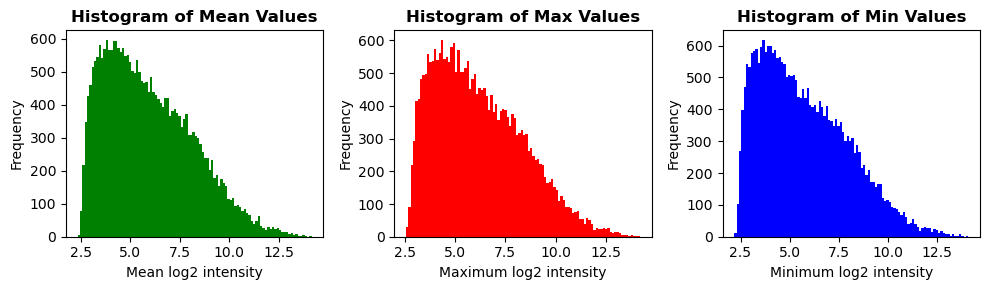

In [15]:
mean_values = expr_with_genotype.iloc[:, 1:].mean()
max_values = expr_with_genotype.iloc[:, 1:].max()
min_values = expr_with_genotype.iloc[:, 1:].min()

fig, ax = plt.subplots(1, 3, figsize = (10, 3))
plt.subplots_adjust(hspace=1)

# Mean Histogram
ax[0].hist(mean_values, bins=100, color='green')
ax[0].set_title('Histogram of Mean Values', fontweight='bold')
ax[0].set_xlabel("Mean log2 intensity")
ax[0].set_ylabel('Frequency')

# Max Histogram
ax[1].hist(max_values, bins=100, color='red')
ax[1].set_title('Histogram of Max Values', fontweight='bold')
ax[1].set_xlabel("Maximum log2 intensity")
ax[1].set_ylabel('Frequency')

# Min Histogram
ax[2].hist(min_values, bins=100, color='blue')
ax[2].set_title('Histogram of Min Values', fontweight='bold')
ax[2].set_xlabel("Minimum log2 intensity")
ax[2].set_ylabel('Frequency')

plt.tight_layout()
# save fig optional          
#plt.savefig('results/app_gene_max_min_ave_distributions.jpg') 

plt.show()

## Sample-wise Boxplots

- Ensure samples are uniform

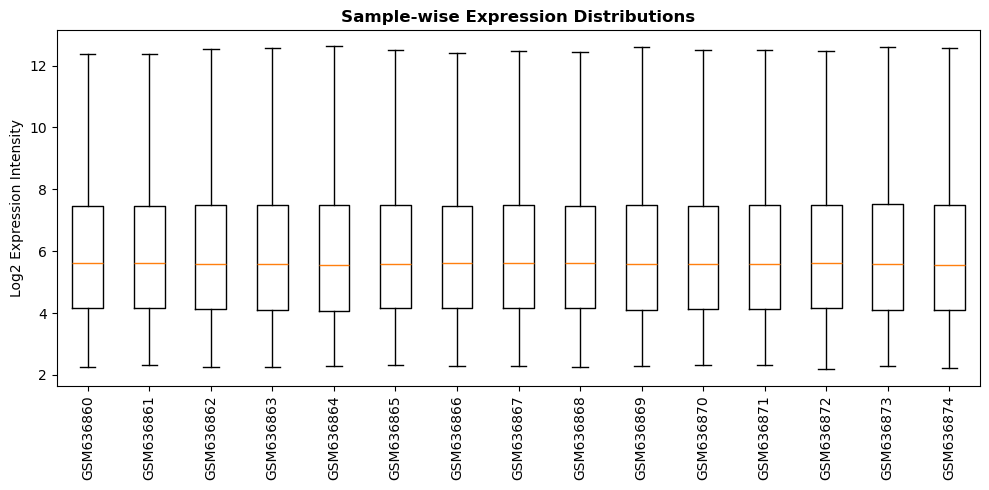

In [24]:
expr_only = expr_with_genotype.iloc[:, 1:]  # remove genotype column

plt.figure(figsize=(10, 5))
plt.boxplot(expr_only.T, showfliers=False)  # <-- transpose here
plt.xticks(
    range(1, expr_only.shape[0] + 1),
    expr_only.index,
    rotation=90
)
plt.ylabel("Log2 Expression Intensity")
plt.title("Sample-wise Expression Distributions", fontweight="bold")
plt.tight_layout()
# save fig optional 
#plt.savefig('results/app_sample_expression_distributions.jpg') 
plt.show()

## Examine Highly Variable Genes

In [62]:
gene_variance = expr_only.var(axis=0)
top_n = 50
top_genes = gene_variance.sort_values(ascending=False).head(top_n).index
print(top_genes)

Index(['Ttr', 'Snca', 'Otx2', 'Folr1', 'Calml4', 'Gh', 'Kcne2', 'Sostdc1',
       'AI854555', 'Mtmr7', 'F5', 'Aplp2', 'Clic6', 'AI506321', 'Aqp1',
       'Kcnj13', '1500015O10Rik', 'Stbd1', 'Slc4a5', 'Steap1', 'Cap1', 'Cdhr1',
       'Egr2', 'S100a8', 'Tmem87a', 'C330006P03Rik', 'Gm21541', 'App',
       'BC021831', 'Kl', 'Nts', 'Arc', 'Krt18', 'AW492145', 'Prr32', 'S100a9',
       '2900001G08Rik', 'Pla2g4e', 'Xaf1', 'Hspa1b', 'Cldn2', 'Wfdc2', 'Frg1',
       'Abhd1', 'BE955100', 'Fos', 'Xlr3b', 'Cd59a', 'BC048679', 'Zic1'],
      dtype='object', name='IDENTIFIER')


In [63]:
# subset the data by top genes based on variance
heatmap_data = expr_only[top_genes]
# Scale the filtered data across samples
scaler = StandardScaler()
heatmap_scaled = pd.DataFrame(
    scaler.fit_transform(heatmap_data),
    index=heatmap_data.index,
    columns=heatmap_data.columns
)

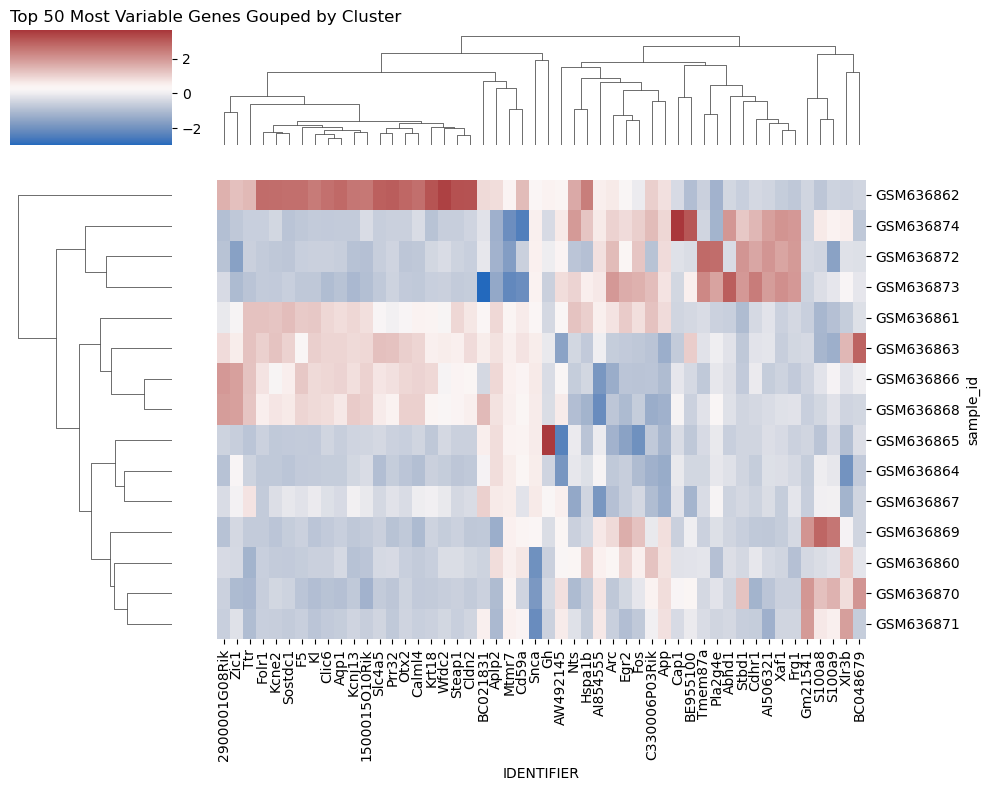

In [68]:
sns.clustermap(
    heatmap_scaled,
    cmap="vlag",
    figsize=(10,8),
    metric="euclidean",
    method="average",
    xticklabels=True
)

plt.title("Top 50 Most Variable Genes Gouped by Cluster", loc='left')
plt.tight_layout()
# save fig optional 
#plt.savefig('results/app_cluster_map.jpg') 
plt.show()

In [22]:
genotype_palette = {
    "WT_R6": "#4daf4a",
    "APP_R6": "#e41a1c",
    "APPsa_R6": "#377eb8",
    "APLP2_R6": "#984ea3",
    "APLP2_R1": "#ff7f00"
}

row_colors = expr_with_genotype["genotype"].map(genotype_palette)

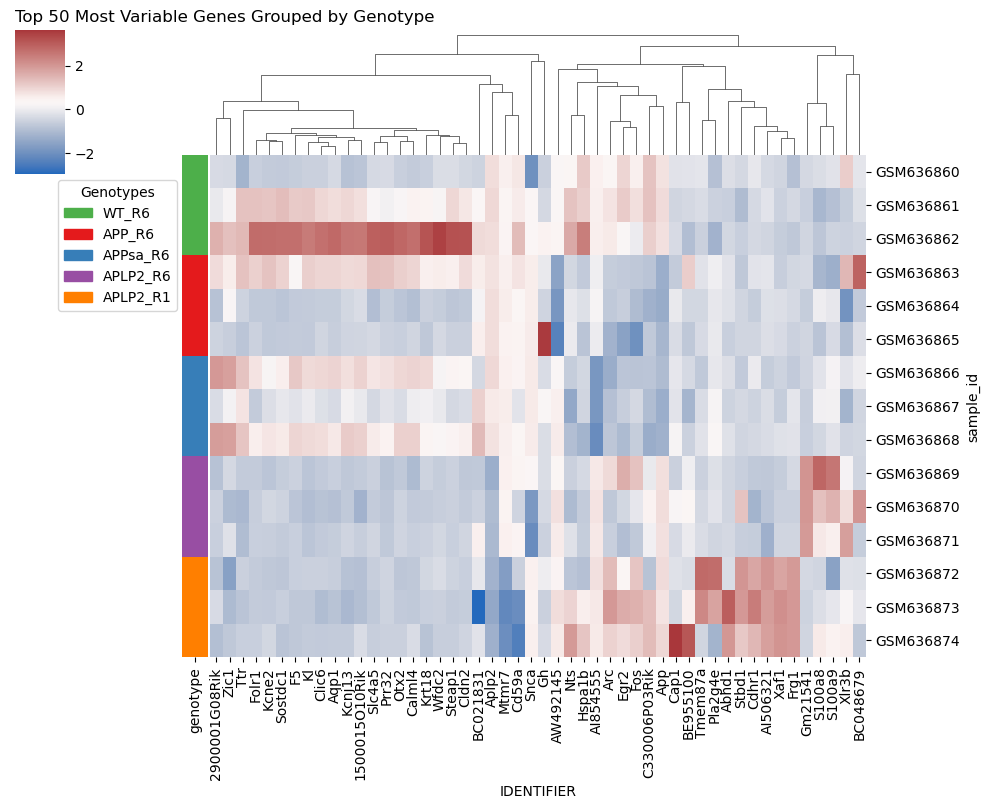

In [48]:
legend_handles = [
    mpatches.Patch(color=color, label=label)
    for label, color in genotype_palette.items()
]

genotype_cluster_plot=sns.clustermap(
    heatmap_scaled,
    cmap="vlag",
    row_colors=row_colors,
    row_cluster=False,
    figsize=(10,8),
    metric="euclidean",
    method="average",
    xticklabels=True,
    yticklabels=True
)

genotype_cluster_plot.ax_heatmap.legend(
    handles=legend_handles,
    title="Genotypes",
    loc="upper right",
    bbox_to_anchor=(-0.05, 0.95),
    borderaxespad=0
)

plt.title("Top 50 Most Variable Genes Grouped by Genotype", loc='left')
# save fig optional 
#plt.savefig('results/app_cluster_map_by_genotype.jpg') 
plt.show()

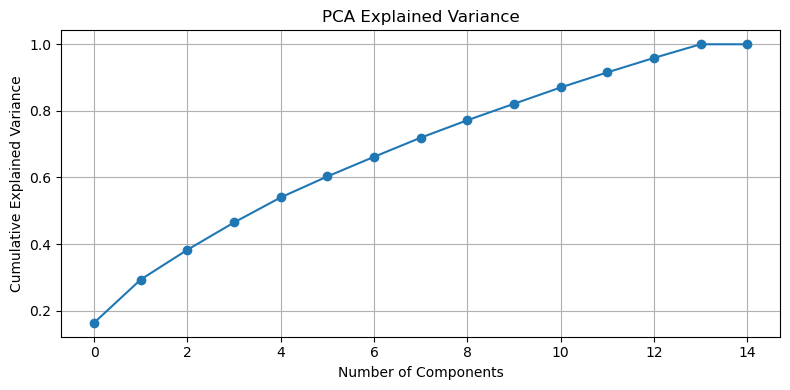

In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(expr_only)

pca = PCA().fit(X_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(explained, marker = 'o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
# save fig optional
#plt.savefig('results/pca_explained_variance.jpg')
plt.show()

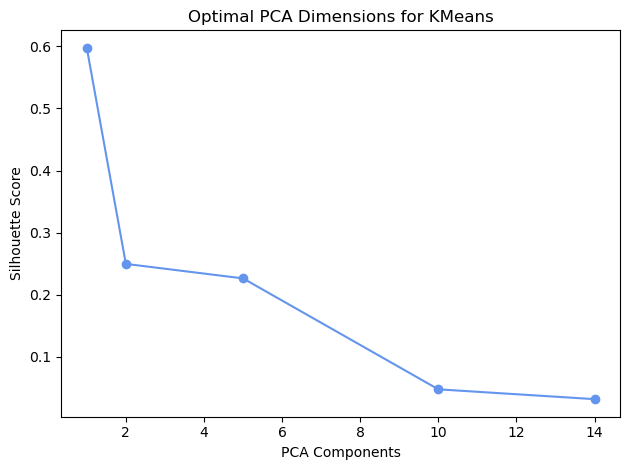

In [43]:
candidate_dims = [1, 2, 5, 10, 14]
sil_scores = []

for k in candidate_dims:
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    
    km_model = KMeans(n_clusters=5, random_state=42)
    km_preds = km_model.fit_predict(X_pca)
    
    sil_score = silhouette_score(X_pca, km_preds)
    sil_scores.append(sil_score)

plt.figsize=(6, 4)
plt.plot(candidate_dims, sil_scores, marker='o', color='cornflowerblue')
plt.ylabel("Silhouette Score")
plt.xlabel("PCA Components")
plt.title("Optimal PCA Dimensions for KMeans")

plt.tight_layout()
# save fig optional
#plt.savefig('results/optimal_pca_dims_kmeans.jpg') 
plt.show()

In [44]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
km_model = KMeans(n_clusters=5, random_state=42)
# fit the model
km_predictions = km_model.fit_predict(X_pca)
# print out results
print("Cluster Labels:")
print(km_predictions)

Cluster Labels:
[2 2 2 0 0 0 0 0 0 3 3 3 0 1 4]


In [45]:
# AgglomerativeClustering model with # clusters = 5 (5 cancer types), ward linkage, and euclidean distance
agg_model = AgglomerativeClustering(n_clusters=5, linkage='ward', metric='euclidean')
# fit the model
agg_predictions = agg_model.fit_predict(expr_only)
# print out results
print("Cluster Labels:")
print(agg_predictions)

Cluster Labels:
[2 2 2 0 0 0 0 0 0 3 3 3 1 4 1]
